In [1]:
# baseline notebook from https://github.com/eriklindernoren/PyTorch-GAN

import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch



In [2]:
os.makedirs("images", exist_ok=True)


n_epochs = 30
batch_size=128
lr=0.002
b1=0.5
b2=0.999
n_cpu=8
latent_dim=100
num_classes=10
img_size=32
channels=1
sample_interval=400


cuda = True if torch.cuda.is_available() else False




In [3]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(num_classes,latent_dim)

        self.init_size = img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise):
        out = self.l1(noise)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, num_classes + 1), nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)

        return validity, label


# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw



In [4]:
# ----------
#  Training
# ----------

d_loss_hist = []
g_loss_hist = []
d_acc_hist = []

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)
        fake_aux_gt = Variable(LongTensor(batch_size).fill_(num_classes), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        validity, _ = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

        # Loss for fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, fake_aux_gt)) / 2

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        # Calculate discriminator accuracy
        pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
        gt = np.concatenate([labels.data.cpu().numpy(), fake_aux_gt.data.cpu().numpy()], axis=0)
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)

        d_loss.backward()
        optimizer_D.step()

        if i%100 == 0:
          print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %d%%] [G loss: %f]"
              % (epoch+1, n_epochs, i, len(dataloader), d_loss.item(), 100 * d_acc, g_loss.item())
          )

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

    d_loss_hist.append(d_loss.item())
    g_loss_hist.append(g_loss.item())
    d_acc_hist.append(100 * d_acc)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[Epoch 1/30] [Batch 0/469] [D loss: 1.545063, acc: 3%] [G loss: 0.694345]
[Epoch 1/30] [Batch 100/469] [D loss: 1.363318, acc: 50%] [G loss: 0.780282]
[Epoch 1/30] [Batch 200/469] [D loss: 1.365871, acc: 50%] [G loss: 0.706081]
[Epoch 1/30] [Batch 300/469] [D loss: 1.408134, acc: 50%] [G loss: 0.721620]
[Epoch 1/30] [Batch 400/469] [D loss: 1.362315, acc: 50%] [G loss: 0.961794]
[Epoch 2/30] [Batch 0/469] [D loss: 1.305050, acc: 49%] [G loss: 0.724465]
[Epoch 2/30] [Batch 100/469] [D loss: 1.387721, acc: 51%] [G loss: 1.067144]
[Epoch 2/30] [Batch 200/469] [D loss: 1.304126, acc: 51%] [G loss: 1.274290]
[Epoch 2/30] [Batch 300/469] [D loss: 1.312522, acc: 53%] [G loss: 0.502261]
[Epoch 2/30] [Batch 400/469] [D loss: 1.231822, acc: 58%] [G loss: 1.202454]
[Epoch 3/30] [Batch 0/469] [D loss: 1.210464, acc: 53%] [G loss: 1.125249]
[Epoch 3/30] [Batch 100/469] [D loss: 1.174219, acc: 59%] [G loss: 0.696058]
[Epoch 3/30] [Batch 200/469] [D loss: 1.157626, acc: 61%] [G loss: 1.348299]
[Epoch

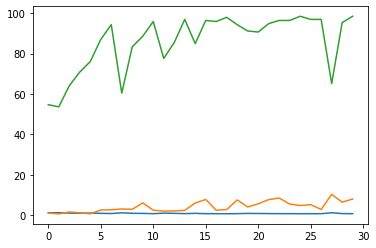

In [9]:
import matplotlib.pyplot as plt

plt.plot(d_loss_hist)
plt.plot(g_loss_hist)
plt.plot(d_acc_hist)

400.png
800.png
1200.png
1600.png
2000.png
2400.png
2800.png
3200.png
3600.png
4000.png
4400.png
4800.png
5200.png
5600.png
6000.png
6400.png
6800.png
7200.png
7600.png
8000.png
8400.png
8800.png
9200.png
9600.png
10000.png
10400.png
10800.png
11200.png
11600.png
12000.png
12400.png
12800.png
13200.png
13600.png
14000.png


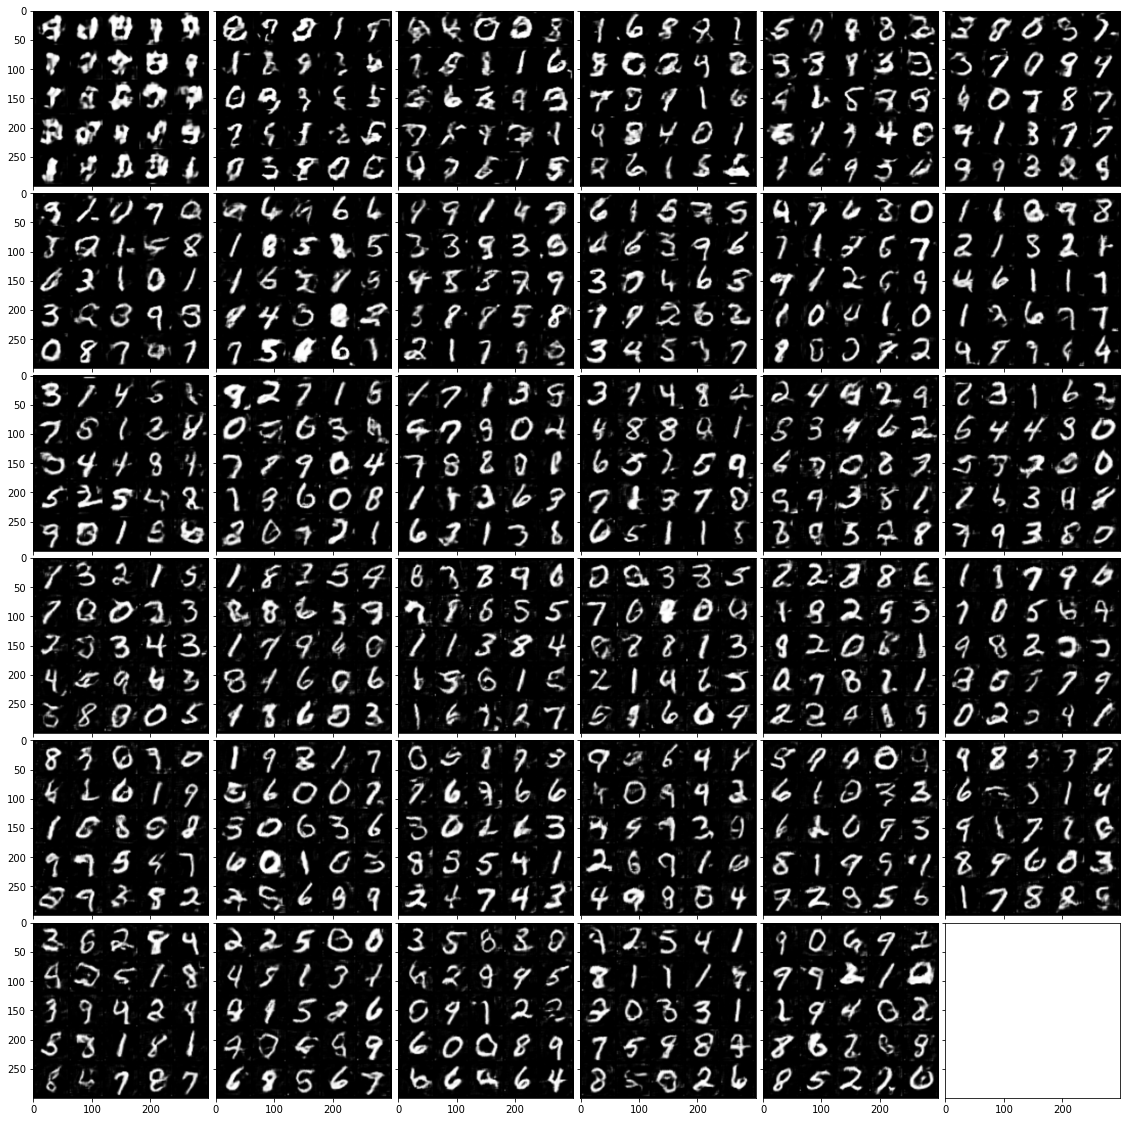

In [28]:

import os
import glob
from os import listdir
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

from PIL import Image


def img_reshape(img):
    img = Image.open('images/'+img).convert('RGB')
    img = img.resize((300,300))
    img = np.asarray(img)
    return img

 
# get the path/directory
images_folder = [s for s in os.listdir("images") if s.endswith('.png')]
images = sorted(images_folder,key=lambda x: int(os.path.splitext(x)[0]))
img_arr = []
# images = list(os.listdir(folder_dir)).sort(key=lambda f: int(filter(str.isdigit, f)))
for image in images:
 
    # check if the image ends with png
    if (image.endswith(".png")):
        print(image)
        img_arr.append(img_reshape(image))





fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(6, 6),  # creates 6x6 grid of axes
                 axes_pad=0.1,  # pad between axes
                 )

for ax, im in zip(grid, img_arr):
    ax.imshow(im)

plt.show()

36

In [19]:
6*6

36